In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from collections import defaultdict
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, './code/')
from dqn_agent import Agent
from auxs import moving_average

#### LOAD THE ENVIRONMENT ####

In [4]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


#### GET ENVIRONMENT PARAMETERS ####

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
#
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

#### HYPER PARAMETERS ####

In [6]:
EPS_START = 1           # START EXPLORING A LOT
GAMMA = 0.99            # discount factor - THE OBJECTIVE OF THE GAME IS TO MAXIMIZE REWARDS AT THE END, HAS TO BE HIGH 

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

##### INITIALIZE DE AGENT #####

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, gamma=GAMMA, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, tau=TAU, lr=LR, update_every=UPDATE_EVERY)

#### CONFIGURE THE AGENT #####

In [8]:
TARGET_AVG_SCORE = 13
NUM_OF_TARGET_EPISODES_FOR_AVG = 100

In [9]:
eps_min = 0.01      # EVEN EXPLORE AFTER MANY EPISODES
eps_decay = 0.995   # DECAY EXPLORE SLOWLY

In [10]:
def choose_action(state, agent, eps=0.):
    
    action = agent.act(state, eps=eps)
    
    return action

def show_graph(lq, avgs, mavgs, title="Training history", moving=False):
    plt.figure(figsize=(10,8))
    plt.plot(lq, ".", label="score")
    plt.plot(avgs, c="r", label="average")
    if moving==True:
        plt.plot(mavgs, c="g", label="moving avg")
        
    plt.axhline(y=13, color='m', linestyle='-.')
    plt.title(title)
    plt.legend()
    plt.show() 

#### TRAIN THE AGENT AND PLOT PROGRESS ####

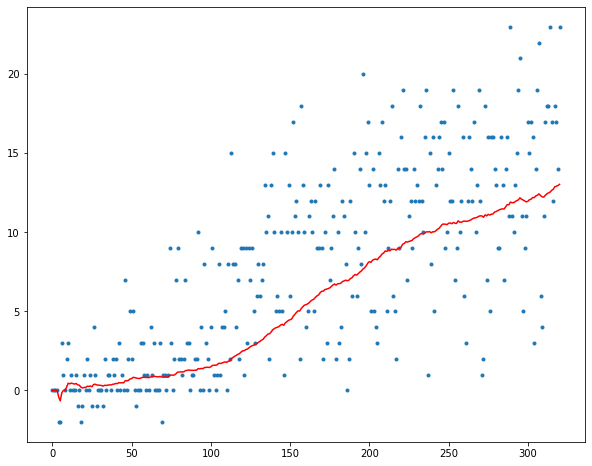

act {0: 57234, 1: 25189, 2: 9690, 3: 4187}
episodes 321 last score 23.0 current eps 0.01 solved 66 avg 13.03
Score: 23.0


In [11]:
trained = False
episodes = 0
la = {0:0,1:0,2:0,3:0}
lq = []
consecutives_solved = 0
times_solved = 0
avg = 0
mav = 0
avgs = []
mavgs = []

eps = EPS_START

while not trained:
    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = choose_action(state, agent)        # select an action
        la[action]+=1
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        if done:                                       # exit loop if episode finished
            break
        agent.step(state, action, reward, next_state, done)
        eps = max(eps_min, eps_decay*eps)
        state = next_state                             # roll over the state to next time step
            
    episodes += 1
    clear_output(wait=True)
    lq.append(score)
    
    avg = np.average(lq[-NUM_OF_TARGET_EPISODES_FOR_AVG:])
    avgs.append(avg)

    plt.figure(figsize=(10,8))
    plt.plot(lq, ".")
    plt.plot(avgs, c="r")
    plt.plot(mavgs, "x", c="c")
    plt.show()    
    print("act", la)
    print("episodes", episodes, "last score", score, "current eps", eps, "solved", times_solved, "avg", avg)
    if score > 13.1:
        times_solved+=1
    else:
        consecutives_solved = 0
    if avg>TARGET_AVG_SCORE:
        trained = True
        torch.save(agent.qnetwork_local.state_dict(), 'model/banana_raytracing_eds.pt')
            
print("Score: {}".format(score))

In [12]:
env.close()

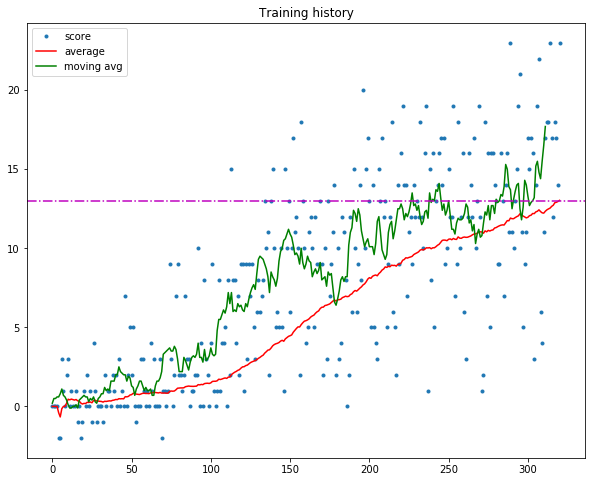

In [13]:
mavgs = moving_average(lq)
show_graph(lq, avgs, mavgs, moving=True)